<h1>План урока<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Домашнее-задание:" data-toc-modified-id="Домашнее-задание:-1">Домашнее задание:</a></span><ul class="toc-item"><li><span><a href="#1.-Сгенерировать-датасет-при-помощи-sklearn.datasets.make_regression-и-обучить-линейную-модель-при-помощи-градиентного-спуска-и-стохастического-градиентного-спуска.-Построить-графики-среднеквадратичной-ошибки-от-числа-итераций-для-обоих-методов-на-одном-рисунке,-сделать-выводы-о-разнице-скорости-сходимости-каждого-из-методов." data-toc-modified-id="1.-Сгенерировать-датасет-при-помощи-sklearn.datasets.make_regression-и-обучить-линейную-модель-при-помощи-градиентного-спуска-и-стохастического-градиентного-спуска.-Построить-графики-среднеквадратичной-ошибки-от-числа-итераций-для-обоих-методов-на-одном-рисунке,-сделать-выводы-о-разнице-скорости-сходимости-каждого-из-методов.-1.1"><strong>1.</strong> Сгенерировать датасет при помощи <code>sklearn.datasets.make_regression</code> и обучить линейную модель при помощи градиентного спуска и стохастического градиентного спуска. Построить графики среднеквадратичной ошибки от числа итераций для обоих методов на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.<br></a></span></li><li><span><a href="#2.-Модифицировать-решение-первого-задания-путем-добавления-L2-регуляризации-и-сравнить-результаты." data-toc-modified-id="2.-Модифицировать-решение-первого-задания-путем-добавления-L2-регуляризации-и-сравнить-результаты.-1.2"><strong>2.</strong> Модифицировать решение первого задания путем добавления L2 регуляризации и сравнить результаты.<br></a></span></li><li><span><a href="#$^*$3.-Модернизировать-решение-задания-2,-заменив-L2-регуляризацию-на-L1-регуляризацию." data-toc-modified-id="$^*$3.-Модернизировать-решение-задания-2,-заменив-L2-регуляризацию-на-L1-регуляризацию.-1.3"><strong>$^*$3.</strong> Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.<br></a></span></li><li><span><a href="#$^*$4.-Построить-график-изменения-весов-от-числа-итераций-при-GD-и-SGD-(на-одном-рисунке)." data-toc-modified-id="$^*$4.-Построить-график-изменения-весов-от-числа-итераций-при-GD-и-SGD-(на-одном-рисунке).-1.4"><strong>$^*$4.</strong> Построить график изменения весов от числа итераций при GD и SGD (на одном рисунке).<br></a></span></li><li><span><a href="#$^*$5.-Построить-график-изменения-весов-для-L1-и-L2-регуляризации-от-коэффициента-регуляризации." data-toc-modified-id="$^*$5.-Построить-график-изменения-весов-для-L1-и-L2-регуляризации-от-коэффициента-регуляризации.-1.5"><strong>$^*$5.</strong> Построить график изменения весов для L1 и L2 регуляризации от коэффициента регуляризации.<br></a></span></li></ul></li></ul></div>

# Урок 2. Масштабирование признаков. Регуляризация. Стохастический градиентный спуск.

## Домашнее задание:

### __1.__ Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного спуска и стохастического градиентного спуска. Построить графики среднеквадратичной ошибки от числа итераций для обоих методов на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.<br>
__Решение:__

__Импорты:__

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
%matplotlib inline

__Создание датасета:__

In [2]:
data, target, coef = datasets.make_regression(n_samples=20000,
                                              n_features = 2,
                                              n_informative = 2,
                                              n_targets = 1, 
                                              noise = 5,
                                              coef = True,
                                              random_state = 42)

In [3]:
print(data)
print(target)
print(coef)

[[-1.47719621  0.61169205]
 [-0.15141607 -1.23725498]
 [ 0.80115196  0.90630674]
 ...
 [ 0.62082995  1.39909748]
 [-0.60021688  0.1990597 ]
 [ 0.12417568 -0.69826185]]
[  -8.66778122 -105.39955764  105.31660491 ...  140.7822377    -2.86429196
  -61.51395316]
[34.54344323 83.17292113]


__Подготовка датасета:__

In [4]:
# Получим средние значения и стандартное отклонение по столбцам

means = np.mean(data, axis=0)
stds = np.std(data, axis=0)
# параметр axis указывается для вычисления значений по столбцам, а не по всему массиву
# (см. документацию в разделе источников)

# вычтем каждое значение признака из среднего и поделим на стандартное отклонение
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        data[i][j] = (data[i][j] - means[j])/stds[j]

__Реализация SGD:__

In [5]:
# реализуем функцию, определяющую среднеквадратичную ошибку для SGD
def mserror(X, w, y_pred):
    y = X.dot(w)
    return (sum((y - y_pred)**2)) / len(y)

In [211]:
%%time
# инициализируем начальный вектор весов
w = np.zeros(2)
 
# список векторов весов после каждой итерации
w_list = [w.copy()]
 
# список значений ошибок после каждой итерации
errors = []
 
# шаг градиентного спуска
eta = 0.5
 
# максимальное число итераций
max_iter = 1e5
 
# критерий сходимости (разница весов, при которой алгоритм останавливается)
min_weight_dist = 1e-8
 
# зададим начальную разницу весов большим числом
weight_dist = np.inf
 
# счетчик итераций
iter_num = 0
 
np.random.seed(1234)
 
# ход градиентного спуска
while weight_dist > min_weight_dist and iter_num < max_iter:
    
    # генерируем случайный индекс объекта выборки
    train_ind = np.random.randint(data.shape[0])
    
    new_w = w - 2 * eta * np.dot(data[train_ind].T, (np.dot(data[train_ind], w) - target[train_ind])) / target.shape[0]
 
    weight_dist = np.linalg.norm(new_w - w, ord=2)
    
    w_list.append(new_w.copy())
    errors.append(mserror(data, new_w, target))
    
    iter_num += 1
    w = new_w
    
w_list = np.array(w_list)
 
print(f'В случае использования стохастического градиентного спуска ошибка MSE составляет: {round(errors[-1], 4)}')
print(f'Количество итераций: {iter_num}')

В случае использования стохастического градиентного спуска ошибка MSE составляет: 131.9359
Количество итераций: 43603
Wall time: 1min 30s


In [7]:
print(w_list)

[[0.00000000e+00 0.00000000e+00]
 [2.77149550e-03 1.78151887e-04]
 [3.28891786e-03 4.61159733e-03]
 ...
 [3.04937805e+01 7.41859930e+01]
 [3.04935465e+01 7.41864111e+01]
 [3.04935465e+01 7.41864111e+01]]


__Реализация GD:__

In [8]:
# реализуем функцию, определяющую среднеквадратичную ошибку для GD
def calc_mse(y, y_pred):
    err = np.mean((y - y_pred)**2)
    return err

In [270]:
# Метод градиентного спуска
error_gd = []


def eval_GD(X, y, iterations, alpha):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        error_gd.append(err)
        w -= alpha * (1/n * 2 * np.dot((y_pred - y), X))
        if i % (iterations / 10) == 0:
            print(f'Итерация = {i}, Подобранные веса = {w}, MSE = {err}')
    return w

In [271]:
%%time
X = data
y = target
w_gd = eval_GD(X, y, iterations=45000, alpha=1e-4)

Итерация = 4500, Подобранные веса = [20.6749537  49.68767109], MSE = 1376.2077352186182
Итерация = 9000, Подобранные веса = [28.82443127 69.92189631], MSE = 247.72258885827847
Итерация = 13500, Подобранные веса = [32.11567857 78.13902811], MSE = 61.901424685092756
Итерация = 18000, Подобранные веса = [33.44483258 81.47603027], MSE = 31.302871810311625
Итерация = 22500, Подобранные веса = [33.98158489 82.83120497], MSE = 26.264235332616465
Итерация = 27000, Подобранные веса = [34.19833342 83.38155204], MSE = 25.434515176344917
Итерация = 31500, Подобранные веса = [34.28585633 83.60505362], MSE = 25.297881807459714
Итерация = 36000, Подобранные веса = [34.32119666 83.69582044], MSE = 25.275381498476015
Итерация = 40500, Подобранные веса = [34.33546594 83.73268222], MSE = 25.27167616923071
Итерация = 45000, Подобранные веса = [34.34122719 83.74765243], MSE = 25.27106596981055
Wall time: 8.41 s


__Визуализация результатов:__

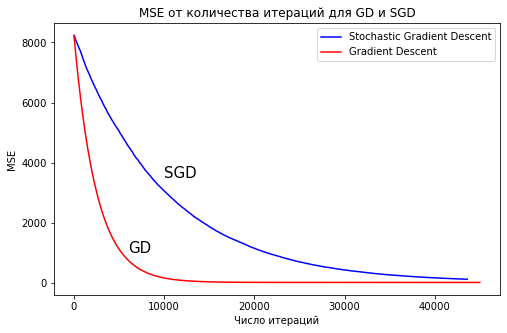

In [232]:
# Визуализируем изменение MSE от количества итераций
plt.figure(figsize=(8,5))
plt.plot(range(len(errors)), errors, 'b', label='Stochastic Gradient Descent')
plt.plot(range(len(error_gd)), error_gd, 'r', label='Gradient Descent')
plt.text(10000, 3500, "SGD", fontsize=15)
plt.text(6000, 1000, "GD", fontsize=15)
plt.title('MSE от количества итераций для GD и SGD')
plt.xlabel('Число итераций')
plt.ylabel('MSE')
plt.legend()

In [124]:
# fg = plt.figure(figsize=(9, 14), constrained_layout=True)
# gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fg)
# fig_ax_1 = fg.add_subplot(gs[0, 0])
# plt.plot(range(len(errors)), errors, 'b', label='Stochastic Gradient Descent')
# plt.plot(range(len(error_gd)), error_gd, 'r', label='Gradient Descent')
# plt.text(2000, 7000, "SGD", fontsize=15)
# plt.title('MSE от количества итераций для GD и SGD')
# plt.xlabel('Число итераций')
# plt.ylabel('MSE')
# plt.legend()
# fig_ax_2 = fg.add_subplot(gs[1, 0])
# plt.plot(range(len(error_gd)), error_gd, 'r', label='Gradient Descent')
# plt.text(1100, 200, "GD", fontsize=15)
# plt.title('MSE от количества итераций для GD')
# plt.xlabel('Число итераций')
# plt.ylabel('MSE')
# plt.legend()

__Выводы:__<br>
Стохастический градиентный спуск в текущем виде работает медленнее обычного градиентного спуска и требует существенно большего количества итераций. Имеет место переобучение модели. На GD получили очень маленькую MSE (25,27) за более короткое время (8,42 с против 1 мин 30 сек у SGD) с коэффициентом обучения равным 0,0001. Скорость сходимости у GD выше чему у SGD.

### __2.__ Модифицировать решение первого задания путем добавления L2 регуляризации и сравнить результаты.<br>
__Решение:__

In [219]:
coef_reg_l2 = []
def eval_model_reg2(X, y, iterations, alpha, lambda_):
    np.random.seed(42)
    w = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations + 1):
        y_pred = np.dot(X, w)
        err = calc_mse(y, y_pred)
        w -= alpha * (1/n * 2 * np.dot((y_pred - y), X) + 2 * lambda_ * w)
        coef_reg_l2.append(w)
        if i % (iterations / 10) == 0:
            print(f'Итерация = {i}, Подобранные веса = {w}, MSE = {err}')
    return w

In [220]:
%%time
w_gd_l2 = eval_model_reg2(X, y, iterations=45000, alpha=1e-4, lambda_=1e-4)

Итерация = 4500, Подобранные веса = [20.67415162 49.68576962], MSE = 1376.3595312383832
Итерация = 9000, Подобранные веса = [28.82257164 69.91740139], MSE = 247.86783942604956
Итерация = 13500, Подобранные веса = [32.11309557 78.13274045], MSE = 61.98382784027555
Итерация = 18000, Подобранные веса = [33.44183782 81.46871426], MSE = 31.341800890657456
Итерация = 22500, Подобранные веса = [33.97837555 82.8233494 ], MSE = 26.281237766749715
Итерация = 27000, Подобранные веса = [34.19501792 83.37342783], MSE = 25.441696371092835
Итерация = 31500, Подобранные веса = [34.28249009 83.59680021], MSE = 25.300889794928384
Итерация = 36000, Подобранные веса = [34.31780675 83.68750639], MSE = 25.27665927275649
Итерация = 40500, Подобранные веса = [34.33206519 83.72434022], MSE = 25.272244845308
Итерация = 45000, Подобранные веса = [34.33782155 83.73929774], MSE = 25.271345602027278
Wall time: 8.32 s


### __$^*$3.__ Модернизировать решение задания 2, заменив L2 регуляризацию на L1 регуляризацию.<br>
__Решение:__

In [256]:
coef_reg_l1 = []
def eval_model_reg1(X, y, iterations, alpha=1e-4, lambda_=1e-8):
    np.random.seed(42)
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    for i in range(1, iterations+1):
        y_pred = np.dot(X, W)
        err = calc_mse(y, y_pred)
        if 0 in W:
            break
        else:
            W -= alpha * (1/n * 2 * np.dot((y_pred - y), X) + lambda_ * W / abs(W))
            coef_reg_l1.append(W)
        if i % (iterations / 10) == 0:
            print(f'Итерация = {i}, Подобранные веса = {W}, MSE = {err}')
    return W

In [259]:
%%time
w_gd_l1 = eval_model_reg1(X, y, iterations=45000, alpha=1e-4, lambda_=1e-4)

Итерация = 4500, Подобранные веса = [20.67492406 49.68764152], MSE = 1376.210568777882
Итерация = 9000, Подобранные веса = [28.82438962 69.92185468], MSE = 247.72420575235466
Итерация = 13500, Подобранные веса = [32.11563204 78.13898159], MSE = 61.90215720795252
Итерация = 18000, Подобранные веса = [33.44478407 81.47598176], MSE = 31.303181468447264
Итерация = 22500, Подобранные веса = [33.98153558 82.83115566], MSE = 26.264362968092517
Итерация = 27000, Подобранные веса = [34.19828378 83.3815024 ], MSE = 25.43456727188407
Итерация = 31500, Подобранные веса = [34.28580657 83.60500386], MSE = 25.29790298913731
Итерация = 36000, Подобранные веса = [34.32114684 83.69577062], MSE = 25.27539009894426
Итерация = 40500, Подобранные веса = [34.33541611 83.73263238], MSE = 25.271679660836043
Итерация = 45000, Подобранные веса = [34.34117735 83.74760258], MSE = 25.271067388721047
Wall time: 9 s


### __$^*$4.__ Построить график изменения весов от числа итераций при GD и SGD (на одном рисунке).<br>
__Решение:__

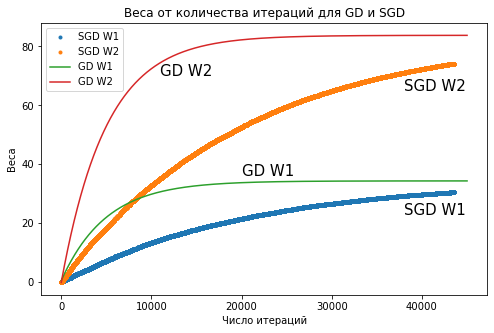

In [235]:
plt.figure(figsize=(8,5))
w1, w2, = plt.plot(range(len(w_list)), w_list, '.')
w3, w4, = plt.plot(range(len(w_gd_list)), w_gd_list, '-')
plt.text(38000, 65, "SGD W2", fontsize=15)
plt.text(38000, 23, "SGD W1", fontsize=15)
plt.text(11000, 70, "GD W2", fontsize=15)
plt.text(20000, 36, "GD W1", fontsize=15)
plt.title('Веса от количества итераций для GD и SGD')
plt.xlabel('Число итераций')
plt.ylabel('Веса')
plt.legend((w1, w2, w3, w4), ['SGD W1', 'SGD W2', 'GD W1', 'GD W2'])

### __$^*$5.__ Построить график изменения весов для L1 и L2 регуляризации от коэффициента регуляризации.<br>
__Решение:__

In [283]:
%%time
n = 2
coeffs = []
lambda_list = np.logspace(-5, -2, n)
for i, val in enumerate(lambda_list):
    W = eval_model_reg2(X, y, iterations=45000, alpha=1e-4, lambda_=val)
    coeffs.append(val.copy())
    coeffs.append(W.copy())

Итерация = 4500, Подобранные веса = [20.67487349 49.68748094], MSE = 1376.222914814143
Итерация = 9000, Подобранные веса = [28.8242453  69.92144679], MSE = 247.73711243673716
Итерация = 13500, Подобранные веса = [32.11542026 78.13839931], MSE = 61.90966133311437
Итерация = 18000, Подобранные веса = [33.44453308 81.47529861], MSE = 31.306759361452336
Итерация = 22500, Подобранные веса = [33.98126393 82.83041935], MSE = 26.265929215989978
Итерация = 27000, Подобранные веса = [34.19800184 83.38073955], MSE = 25.435226411681736
Итерация = 31500, Подобранные веса = [34.28551968 83.60422821], MSE = 25.298175466459465
Итерация = 36000, Подобранные веса = [34.32085764 83.69498896], MSE = 25.275502016330055
Итерация = 40500, Подобранные веса = [34.33512584 83.73184794], MSE = 25.271725722439697
Итерация = 45000, Подобранные веса = [34.3408866  83.74681688], MSE = 25.27108659394836


TypeError: list indices must be integers or slices, not tuple

In [284]:
print(coeffs)

[]


__Комментарии преподавателя:__<br>
Михаил, добрый вечер!
новый файл для проверки - https://github.com/MikhailDemin/GB_DataScience-in-Med/blob/af2799176c94d9d3868c6677f5fd71af3c5a927d/09_Data_analyze_algorhytms/09_lesson_2_my_solution.ipynb
сгенерированные данные имеют один масштаб, поэтому их стандартизацию можно было не выполнять. хотя на результат это не повлияло.
- 1) вы проверили работу стохастического градиентного спуска и градиентного спуска. график построен. вывод сделан.
почему вы решили, что здесь переобучение? по маленькой mse? можно было бы проверить ошибку с истинными весами (coef) и сравнить с полученной по методу GD, они близки. по чему еще можно определить факт переобучения? по ошибке на трейне и на тесте, но проверки здесь такой нет. по росту некоторых весов, но они соответствуют истинным. вопрос к вам остался.
- 2) L2 добавлена верно, но чтобы увидеть влияние регуляризации, надо задавать больше lambda_.
- 3) lambda_ * W / abs(W) добавлено верно. рекомендация та же.
- 4) отличный график. видим, что по SGD получаем веса чуть меньше, методу не хватило итераций. можно было бы задать побольше скорость обучения.

Методичка https://colab.research.google.com/drive/1nEC_D2y-maMuvbN-5iYFAjzLUw0eGOir